In [8]:
#%% [markdown]
# Entity Subspace Learning
# This notebook demonstrates the training and evaluation of the EntitySubspaceLearner model

#%% Imports
%reload_ext autoreload
%autoreload 2

import torch
from pathlib import Path
from subspace_training import EntitySubspaceLearner, train
from subspace_evaluation import (
    analyze_subspace,
    compare_pca_spaces,
    visualize_singular_values,
    visualize_entity_projections,
    plot_training_history,
    visualize_pca_many_components,
)
import matplotlib.pyplot as plt

In [9]:

#%% Setup directories
# Create directories for saving artifacts and images
Path("artifacts").mkdir(exist_ok=True)
Path("images").mkdir(exist_ok=True)

#%% Load data
# Load cached activations
activations = torch.load('artifacts/activation_cache.pt')
print(f"Loaded activations with shape: {activations.shape}")

Loaded activations with shape: torch.Size([1000, 3, 2304])


/tmp/ipykernel_3568979/2668656612.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  activations = torch.load('artifacts/activation_cache.pt')


/share/u/can/by_reference/subspace_training.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  activations = torch.load(file_path)


Train size: 450, Validation size: 50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epochs: 100%|██████████| 10/10 [00:00<00:00, 45.06it/s, train_loss=0.4824, val_loss=0.5834]


tensor(0.9701)

Subspace Analysis (Validation Set):
Intra-cluster distance: 0.9701
Inter-cluster distance: 0.5036
Effective rank: 2

PCA Analysis:
Original space explained variance: [0.25775677 0.08615548]
P_e projected space explained variance: [0.87647647 0.12007339]


/tmp/ipykernel_3568979/330392022.py:61: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(U @ pc0)


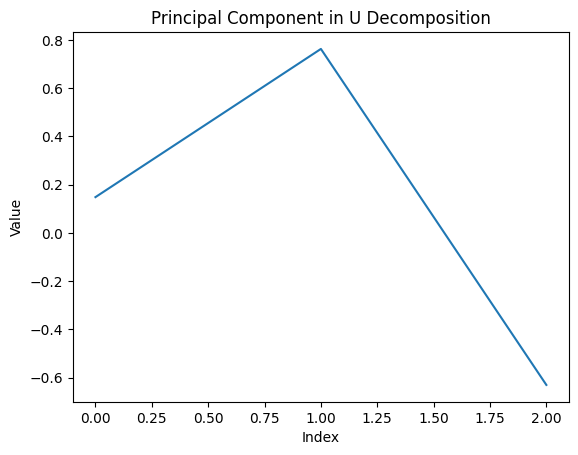

In [10]:
#%% Train model
# Train the EntitySubspaceLearner
activation_files = {
    0: "artifacts/activation_cache_entity0.pt",
    1: "artifacts/activation_cache_entity1.pt",
    2: "artifacts/activation_cache_entity2.pt",
    3: "artifacts/activation_cache_entity3.pt",
    4: "artifacts/activation_cache_entity4.pt"
}

learner, history, train_dataset, val_dataset = train(
    activation_files=activation_files,
    subspace_dim=3,
    lr=1e-3,
    align_coeff=1.0,
    separate_coeff=1.0,
    separate_margin=0.0,
    rank_coeff=0.01,
    batch_size=100,
    num_epochs=10,
    patience=50,
    val_size=0.1,
    force_orthogonal=False,
)

#%% Plot training history
plot_training_history(history['train'], history['val'], learner)

#%% Analyze subspace
# Get validation data for analysis

entity_vectors, entity_labels = val_dataset.dataset[val_dataset.indices]
entity_labels -= 1 # Shift to 0-based indexing
Pe = learner.P_e.detach().cpu()

# Analyze subspace properties
intra_dist, inter_dist, eff_rank, U, S, V = analyze_subspace(Pe, entity_vectors, entity_labels)

print("\nSubspace Analysis (Validation Set):")
print(f"Intra-cluster distance: {intra_dist:.4f}")
print(f"Inter-cluster distance: {inter_dist:.4f}")
print(f"Effective rank: {eff_rank}")

# Plot singular values
visualize_singular_values(S)

# Visualize entity projections
visualize_entity_projections(entity_vectors, entity_labels, V)

# Compare PCA spaces
pca_statistics, pca_pe_components = compare_pca_spaces(Pe, entity_vectors, entity_labels)
print("\nPCA Analysis:")
print("Original space explained variance:", pca_statistics['orig_explained_var'])
print("P_e projected space explained variance:", pca_statistics['pe_explained_var'])


# #%% Plot principal component in U decomposition
pc0 = pca_pe_components[0]
plt.figure()

plt.plot(U @ pc0)
plt.title("Principal Component in U Decomposition")
plt.xlabel("Index")
plt.ylabel("Value")
plt.savefig("images/principal_component_in_U_decomposition.png")

In [11]:
all_entity_vectors, all_entity_labels = train_dataset.dataset[train_dataset.indices]
visualize_pca_many_components(all_entity_vectors, all_entity_labels, n_components=10)

Total variance explained by 10 components: 0.588


PCA(n_components=10)

In [5]:
import torch
import numpy as np
from IPython.display import display, HTML
import einops
import datasets
from nnsight import LanguageModel
from torch.nn.functional import normalize

# %% [markdown]
# ## Experimental Configuration

# %%
# Model Configuration
MODEL_NAME = "gemma-2-9b"
MODEL_CACHE_DIR = "/share/u/can/models"
DEVICE = torch.device("cuda:0")

# Analysis Configuration
LAYERS_TO_ANALYZE = [12]
NUM_ENTITIES = 3
BATCH_SIZE = 50
NUM_BATCHES = 20
NUM_SINGULAR_VECTORS = 2
NUM_VISUALIZATIONS_PER_VECTOR = 5

# OpenWebText Configuration
WEBTEXT_DATASET = "Skylion007/openwebtext"
WEBTEXT_BATCH_SIZE = 5
WEBTEXT_NUM_BATCHES = 10
MAX_SEQ_LENGTH = 64

# Tracer Configuration
TRACER_KWARGS = {"scan": False, "validate": False}

# %% [markdown]
# ## Visualization Functions


# %%
def get_color_gradient(value, vmin, vmax):
    """
    Convert value to RGB color string:
    negative -> red
    zero -> white
    positive -> blue
    """
    abs_max = max(abs(vmin), abs(vmax))
    normalized = value / abs_max if abs_max != 0 else 0

    if normalized < 0:  # Red for negative
        r = 255
        g = b = int(255 * (1 + normalized))
    else:  # Blue for positive
        b = 255
        r = g = int(255 * (1 - normalized))

    return f"rgb({r}, {g}, {b})"


def get_text_color(value, abs_max):
    """Return black for abs(value) < 0.5, white for abs(value) >= 0.5"""
    return "white" if abs(value) >= 0.5 * abs_max else "black"


def visualize_token_activations(tokens, activations):
    """
    Visualize tokens as colored inline rectangles with their activation values.
    """
    if isinstance(activations, torch.Tensor):
        activations = activations.detach().cpu().numpy()

    if len(tokens) != len(activations):
        raise ValueError(
            f"Length mismatch: {len(tokens)} tokens vs {len(activations)} activation values"
        )

    vmin, vmax = np.min(activations), np.max(activations)
    abs_max = max(abs(vmin), abs(vmax))

    scale_ref = f"""
        <div style='margin-bottom: 20px;'>
            <span style='margin-right: 15px; font-size: 0.9em;'>
                Scale: 
                <span style='background-color: {get_color_gradient(vmin, vmin, vmax)}; 
                           color: {get_text_color(vmin, abs_max)}; 
                           padding: 2px 8px; 
                           border-radius: 3px;'>
                    min: {vmin:.3f}
                </span>
                <span style='background-color: white; 
                           color: black; 
                           padding: 2px 8px; 
                           border-radius: 3px; 
                           margin: 0 5px;'>
                    0.000
                </span>
                <span style='background-color: {get_color_gradient(vmax, vmin, vmax)}; 
                           color: {get_text_color(vmax, abs_max)}; 
                           padding: 2px 8px; 
                           border-radius: 3px;'>
                    max: {vmax:.3f}
                </span>
            </span>
        </div>
    """

    tokens_html = ""
    for token, value in zip(tokens, activations):
        bg_color = get_color_gradient(value, vmin, vmax)
        text_color = get_text_color(value, abs_max)

        tokens_html += f"""
            <span class='token-box' style='background-color: {bg_color}; color: {text_color};'>
                <span class='activation-value' style='color: #666;'>{value:.3f}</span>
                {token}
            </span>
        """

    html_output = f"""
    <div style='font-family: monospace; line-height: 2.5; background-color: white; padding: 20px;'>
        <style>
            .token-box {{
                display: inline-block;
                padding: 4px 8px;
                margin: 2px;
                border-radius: 3px;
                font-weight: bold;
                position: relative;
            }}
            .activation-value {{
                position: absolute;
                top: -18px;
                left: 50%;
                transform: translateX(-50%);
                font-size: 0.8em;
                white-space: nowrap;
            }}
        </style>
        {scale_ref}
        {tokens_html}
    </div>
    """

    display(HTML(html_output))


# %% [markdown]
# ## Model Setup

# %%
# Initialize model
from activation_cache import load_model
model = load_model(MODEL_NAME)

# %% [markdown]
# ## Data Processing

# %%


# %% [markdown]
# ## OpenWebText Analysis
# %%
# ds_web = datasets.load_dataset(WEBTEXT_DATASET, split="train", streaming=True)

import json

with open("data/dataset.json", "r") as f:
    ds_web = json.load(f)


# Load OpenWebText dataset
def tokenized_batches(ds_web, batch_size, num_batches, max_length=128):
    ds_web = iter(ds_web)
    batches = []
    for i in range(num_batches):
        batch = [next(ds_web)["text"] for _ in range(batch_size)]
        tokenized = model.tokenizer.batch_encode_plus(
            batch,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=max_length,
            padding_side="right",
        )
        batches.append(tokenized)
    return batches


web_token_id_batches = tokenized_batches(
    ds_web, WEBTEXT_BATCH_SIZE, WEBTEXT_NUM_BATCHES, MAX_SEQ_LENGTH
)

# Extract activations from OpenWebText
web_acts_bBLD = torch.zeros(
    (WEBTEXT_NUM_BATCHES, WEBTEXT_BATCH_SIZE, MAX_SEQ_LENGTH, model.config.hidden_size)
)

for batch_idx, token_ids in enumerate(web_token_id_batches):
    token_ids = token_ids.to(DEVICE)
    with torch.no_grad(), model.trace(token_ids, **TRACER_KWARGS):
        for layer in LAYERS_TO_ANALYZE:
            web_acts_bBLD[batch_idx] = model.model.layers[layer].output[0].save()

torch.cuda.empty_cache()

# Process OpenWebText activations
web_acts_ALD = einops.rearrange(web_acts_bBLD, "b B L D -> (b B) L D")
# normalize along final dimension
web_acts_ALD = normalize(web_acts_ALD, dim=-1)

web_token_AL = torch.zeros(
    (WEBTEXT_NUM_BATCHES * WEBTEXT_BATCH_SIZE, MAX_SEQ_LENGTH), dtype=torch.long
)

for i, token_ids in enumerate(web_token_id_batches):
    start_idx = i * WEBTEXT_BATCH_SIZE
    end_idx = (i + 1) * WEBTEXT_BATCH_SIZE
    web_token_AL[start_idx:end_idx] = token_ids["input_ids"]

web_str_AL = [
    [model.tokenizer.decode(token_id) for token_id in current_token_ids]
    for current_token_ids in web_token_AL
]

# %% [markdown]
# ## Visualization of Results

# %%
# Visualize activations along V directions
data_along_pc = web_acts_ALD @ Pe.T @ pc0

print("##################")
print(f"Identified entity vector")
print("##################")

for i in range(len(web_str_AL)):
    visualize_token_activations(web_str_AL[i], data_along_pc[i])
    if i > NUM_VISUALIZATIONS_PER_VECTOR:
        break

# %%

/share/u/can/miniconda3/envs/reference_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


##################
Identified entity vector
##################


/tmp/ipykernel_573817/2536318178.py:231: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data_along_pc = web_acts_ALD @ Pe.T @ pc0
